# Compiling ABC
From String to Binaries

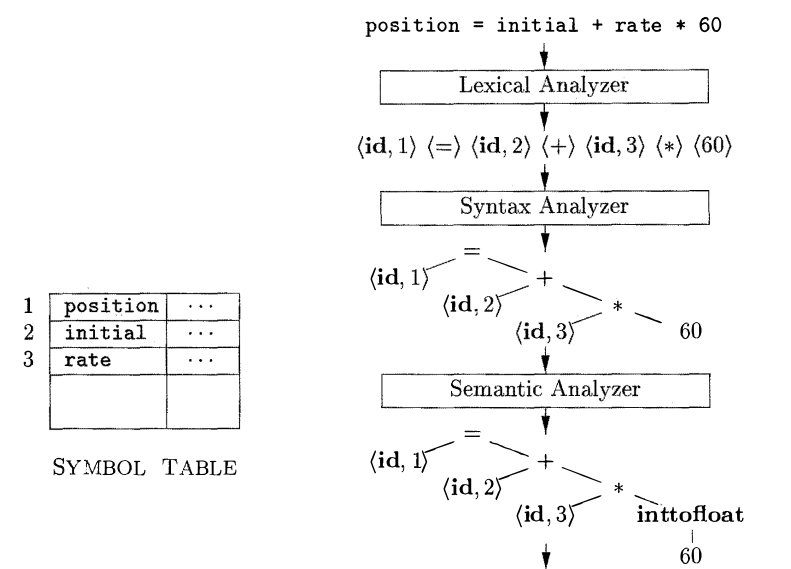

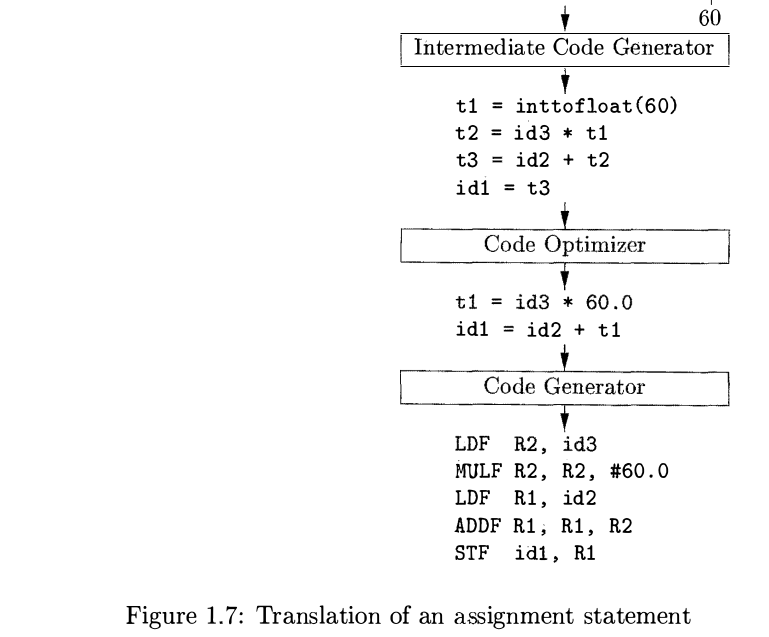

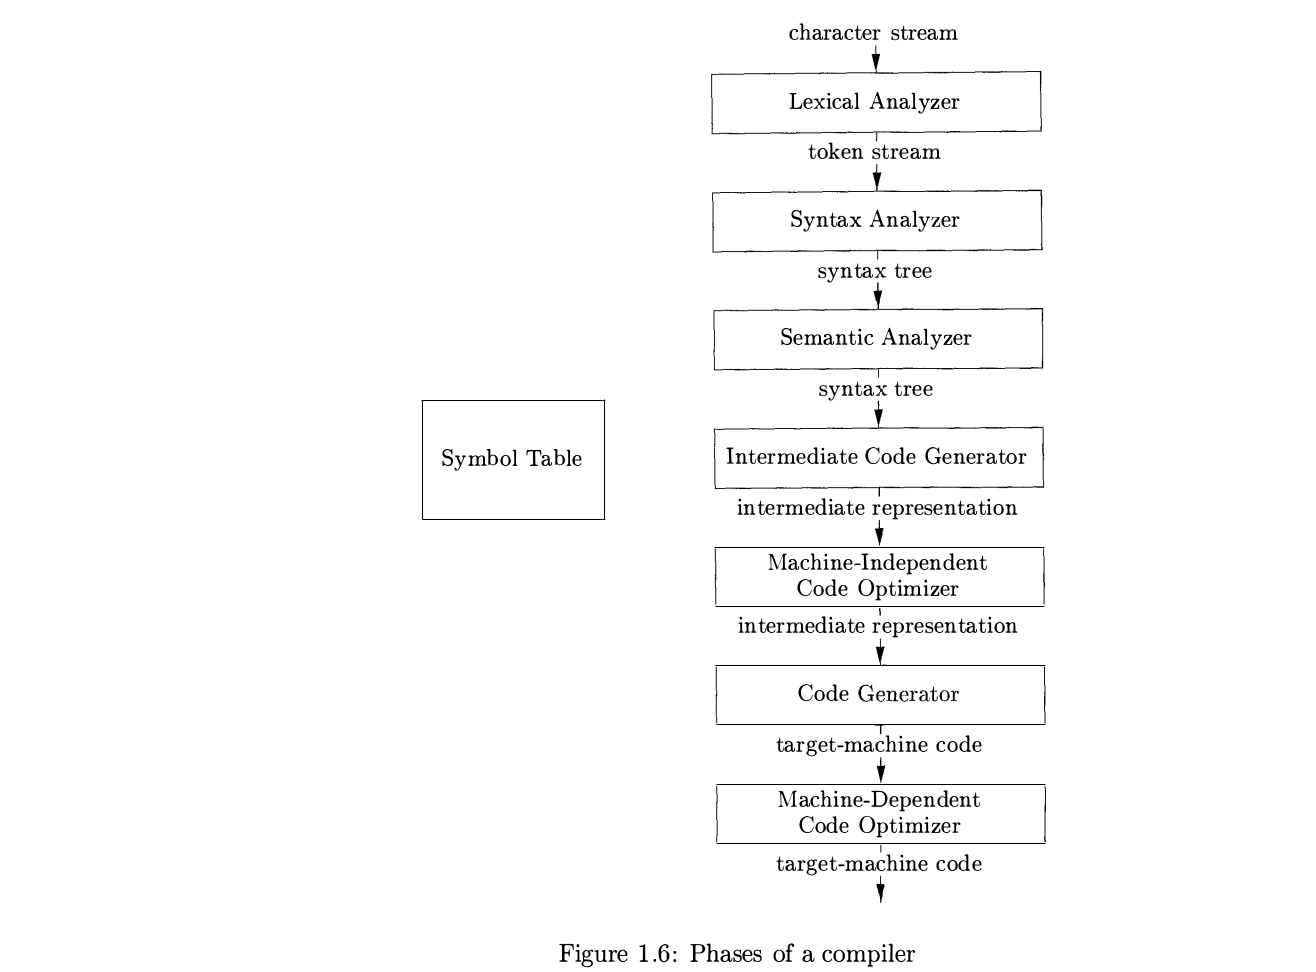

# The dragon Book
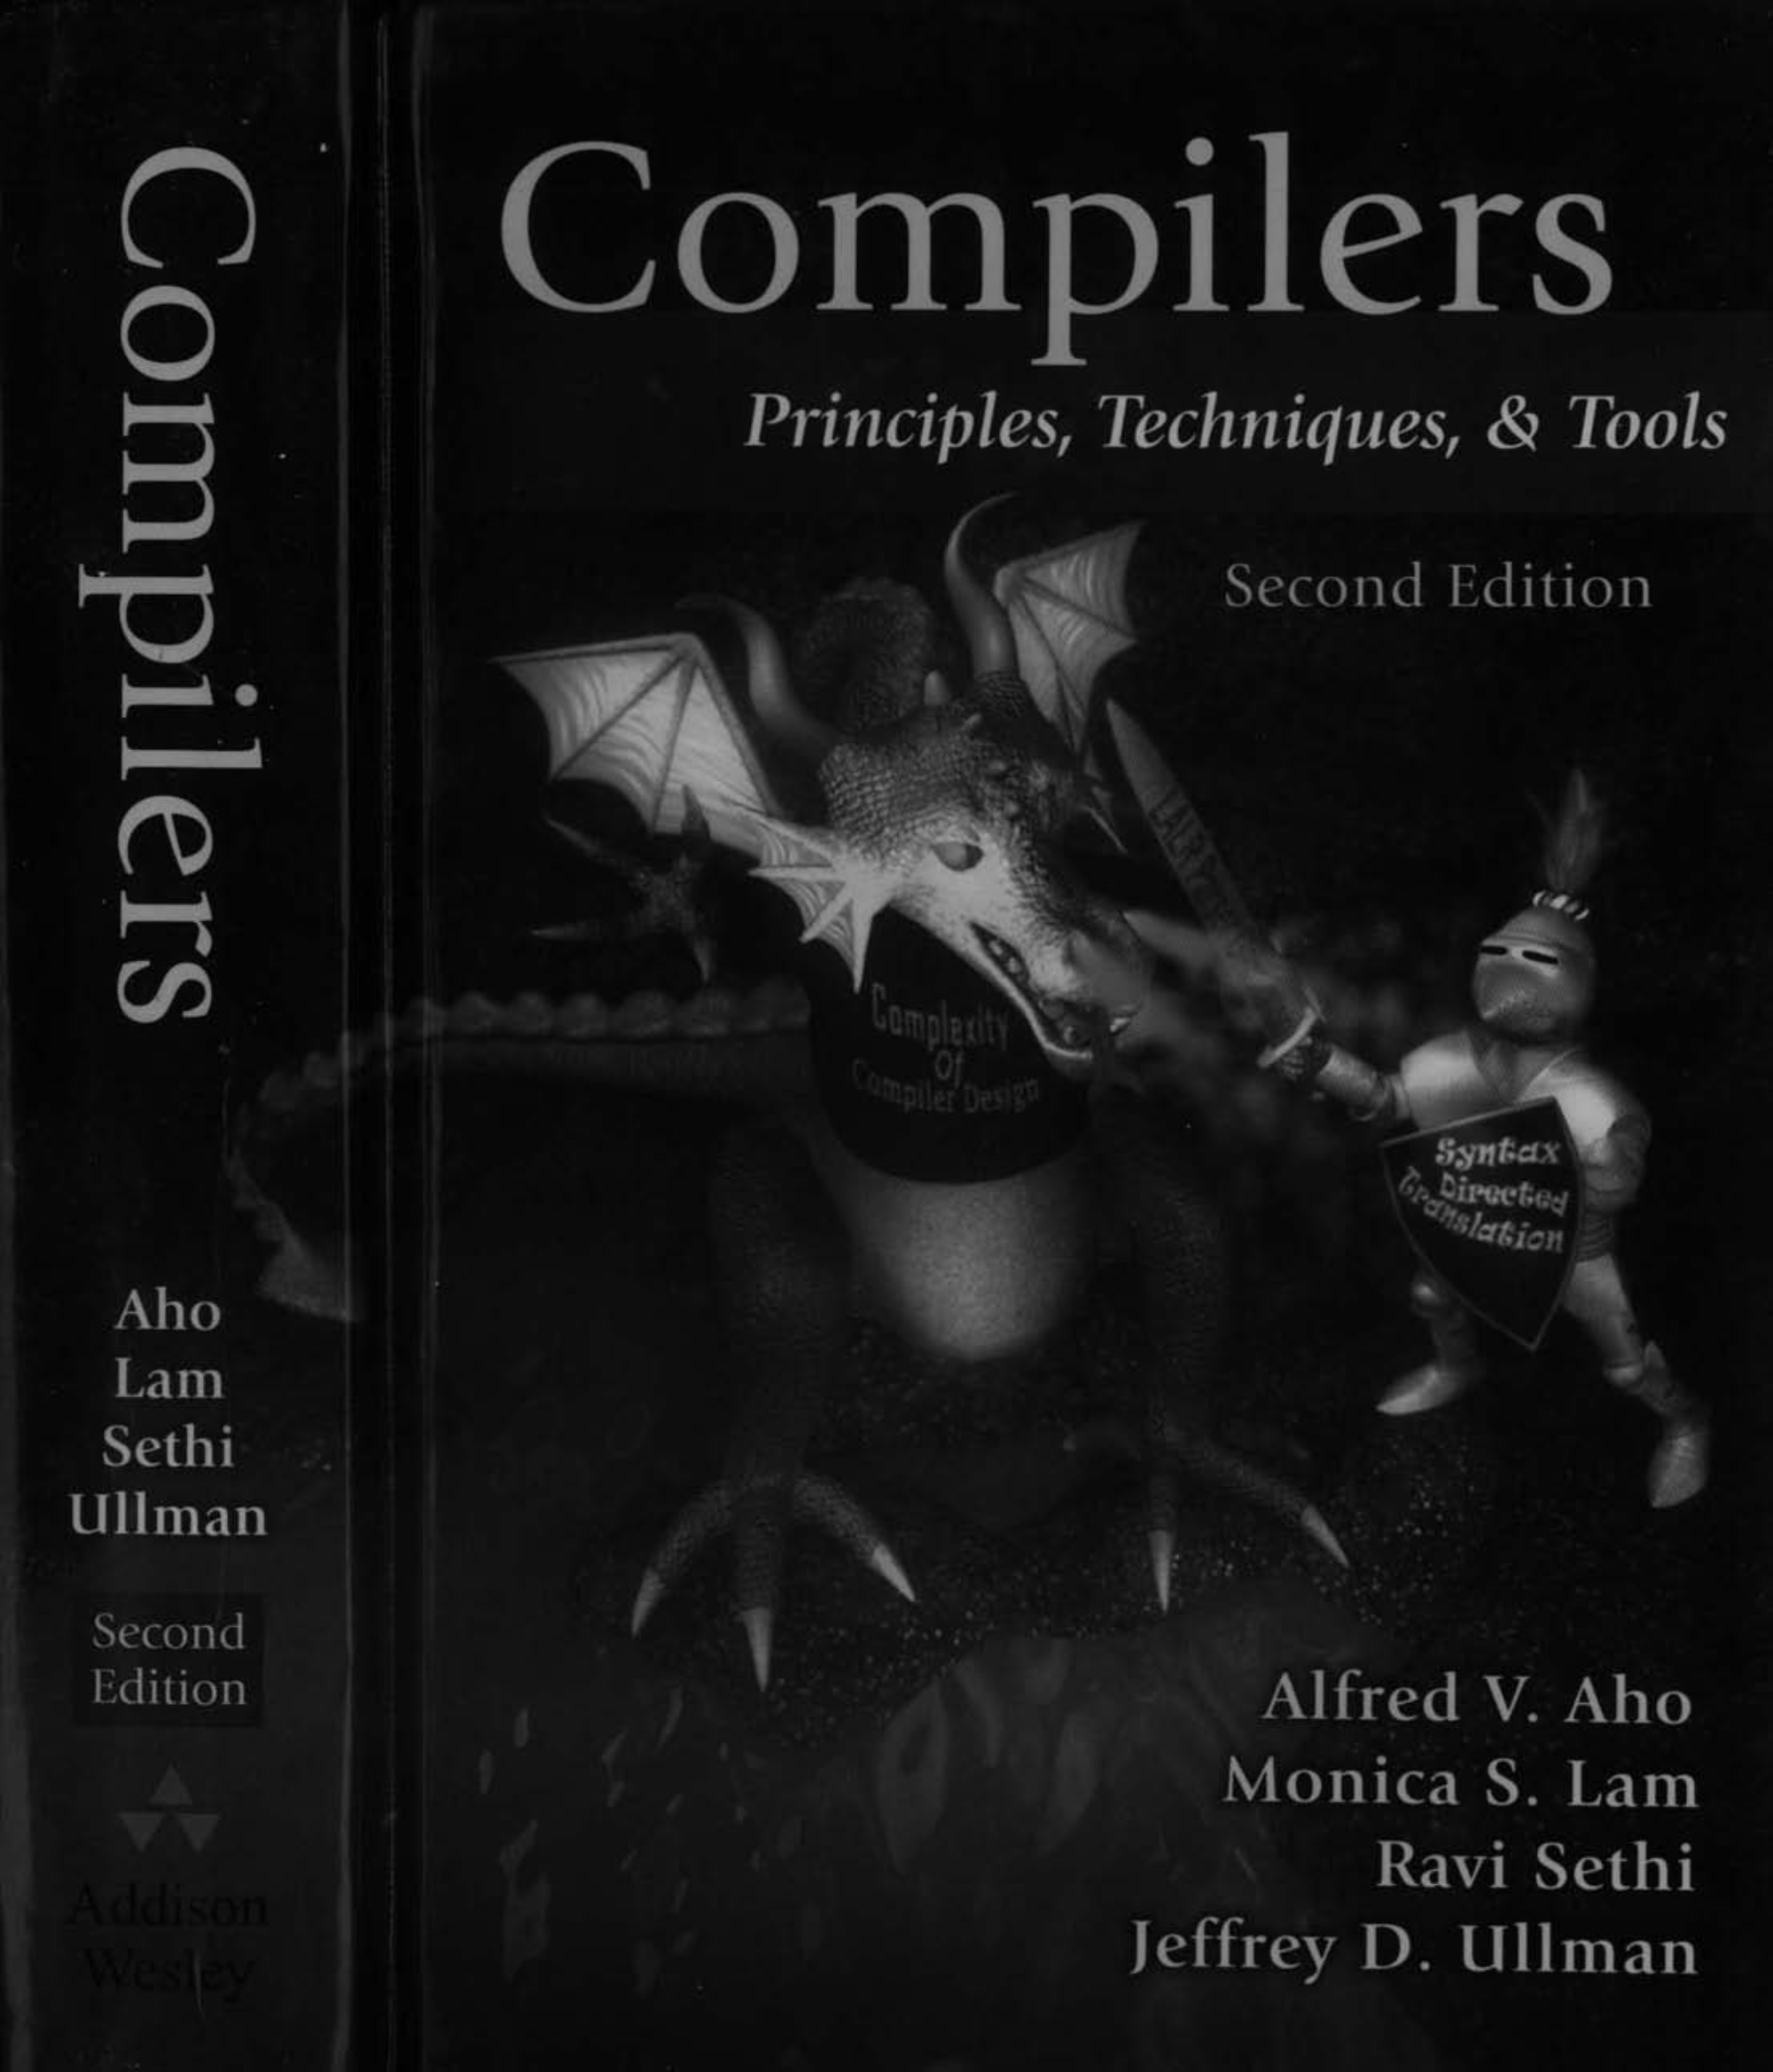

# Julia Compiling
* Layer 1: The AST after parsing
* Layer 2: The AST after lowering
* Layer 3: The AST after type inference and optimization
* Layer 4: The LLVM IR
* Layer 5: The assembly code

## References
* Introducing Julia/Metaprogramming
https://en.wikibooks.org/wiki/Introducing_Julia/Metaprogramming
* Julia ASTs
https://docs.julialang.org/en/latest/devdocs/ast/
* Julia Introspects
http://blog.leahhanson.us/post/julia/julia-introspects.html


In [87]:
function f(x, y)
    for i=1:x
        x += y
    end
    return x
end

f (generic function with 1 method)

In [88]:
f(3, 6)

21

# Layer 1: The AST after parsing (the surface syntax AST)

In [121]:
ex = Meta.parse("""
function f(x, y)
    for i=1:x
        x + y
    end
    return x
end
""")

:(function f(x, y)
      #= none:2 =#
      for i = 1:x
          #= none:3 =#
          x + y
      end
      #= none:5 =#
      return x
  end)

# Or, equivalently, we write

In [123]:
ex = :(function f(x, y)
    for i=1:x
        x + y
    end
    return x
end)

:(function f(x, y)
      #= In[123]:2 =#
      for i = 1:x
          #= In[123]:3 =#
          x + y
      end
      #= In[123]:5 =#
      return x
  end)

In [112]:
ex.head

:function

In [113]:
ex.args[1]

:(f(x, y))

In [92]:
ex.args[1].head

:call

In [93]:
ex.args[1].args

3-element Array{Any,1}:
 :f
 :x
 :y

In [94]:
ex.args[2]

quote
    #= In[89]:2 =#
    for i = 1:x
        #= In[89]:3 =#
        x + y
    end
    #= In[89]:5 =#
    return x
end

In [95]:
ex.args[2].head

:block

In [96]:
ex.args[2].args

4-element Array{Any,1}:
 :(#= In[89]:2 =#)                                    
 :(for i = 1:x
      #= In[89]:3 =#
      x + y
  end)
 :(#= In[89]:5 =#)                                    
 :(return x)                                          

# Layer 2: The AST after lowering

In [97]:
code_lowered(f, (Int, Int))

1-element Array{Core.CodeInfo,1}:
 CodeInfo(
1 ─       x@_6 = x@_2
│   %2  = 1:x@_6
│         #temp# = (Base.iterate)(%2)
│   %4  = #temp# === nothing
│   %5  = (Base.not_int)(%4)
└──       goto #4 if not %5
2 ┄ %7  = #temp#
│         i = (Core.getfield)(%7, 1)
│   %9  = (Core.getfield)(%7, 2)
│         x@_6 = x@_6 + y
│         #temp# = (Base.iterate)(%2, %9)
│   %12 = #temp# === nothing
│   %13 = (Base.not_int)(%12)
└──       goto #4 if not %13
3 ─       goto #2
4 ┄       return x@_6
)

# Layer 3: The AST after type inference and optimization

In [98]:
code_typed(f, (Int, Int))

1-element Array{Any,1}:
 CodeInfo(
1 ── %1  = (Base.sle_int)(1, x)::Bool
│    %2  = (Base.ifelse)(%1, x, 0)::Int64
│    %3  = (Base.slt_int)(%2, 1)::Bool
└───       goto #3 if not %3
2 ──       goto #4
3 ──       goto #4
4 ┄─ %7  = φ (#2 => true, #3 => false)::Bool
│    %8  = φ (#3 => 1)::Int64
│    %9  = (Base.not_int)(%7)::Bool
└───       goto #10 if not %9
5 ┄─ %11 = φ (#4 => %8, #9 => %19)::Int64
│    %12 = φ (#4 => _2, #9 => %13)::Int64
│    %13 = (Base.add_int)(%12, y)::Int64
│    %14 = (%11 === %2)::Bool
└───       goto #7 if not %14
6 ──       goto #8
7 ── %17 = (Base.add_int)(%11, 1)::Int64
└───       goto #8
8 ┄─ %19 = φ (#7 => %17)::Int64
│    %20 = φ (#6 => true, #7 => false)::Bool
│    %21 = (Base.not_int)(%20)::Bool
└───       goto #10 if not %21
9 ──       goto #5
10 ┄ %24 = φ (#8 => %13, #4 => _2)::Int64
└───       return %24
) => Int64

# Layer 4: The LLVM IR

In [99]:
code_llvm(f, (Int, Int))


;  @ In[87]:2 within `f'
define i64 @julia_f_13352(i64, i64) {
top:
; ┌ @ range.jl:5 within `Colon'
; │┌ @ range.jl:274 within `Type'
; ││┌ @ range.jl:279 within `unitrange_last'
; │││┌ @ operators.jl:333 within `>='
; ││││┌ @ int.jl:428 within `<='
       %2 = icmp sgt i64 %0, 0
; └└└└└
  %3 = mul i64 %1, %0
  %4 = select i1 %2, i64 %3, i64 0
  %value_phi6 = add i64 %4, %0
;  @ In[87]:5 within `f'
  ret i64 %value_phi6
}


# Layer 5: The assembly code

In [140]:
code_native(f, (Int, Int))

	.text
; ┌ @ In[132]:2 within `f'
	pushq	%r14
	pushq	%rbx
	subq	$40, %rsp
	vxorps	%xmm0, %xmm0, %xmm0
	vmovaps	%xmm0, (%rsp)
	movq	$0, 16(%rsp)
	movq	%fs:0, %r14
; │┌ @ range.jl:5 within `Colon'
; ││┌ @ range.jl:274 within `Type'
; │││┌ @ range.jl:279 within `unitrange_last'
; ││││┌ @ operators.jl:333 within `>='
; │││││┌ @ int.jl:428 within `<='
	movq	$2, (%rsp)
	movq	-15552(%r14), %rax
	movq	%rax, 8(%rsp)
	movq	%rsp, %rax
	movq	%rax, -15552(%r14)
	movq	%rsi, %rbx
; │└└└└└
	imulq	%rdi, %rbx
	xorl	%eax, %eax
; │┌ @ range.jl:5 within `Colon'
; ││┌ @ range.jl:274 within `Type'
; │││┌ @ range.jl:279 within `unitrange_last'
; ││││┌ @ operators.jl:333 within `>='
; │││││┌ @ int.jl:428 within `<='
	testq	%rdi, %rdi
; │└└└└└
	cmovleq	%rax, %rbx
	addq	%rdi, %rbx
; │ @ In[132]:5 within `f'
; │┌ @ io.jl:208 within `repr'
; ││┌ @ io.jl:208 within `#repr#341'
; │││┌ @ none within `#sprint'
	movabsq	$"#sprint#340", %rax
	movabsq	$jl_system_image_data, %rsi
	movabsq	$jl_system_image_data, %rdx
	xorl

# Julia Compiling (with macro)

# Layer 1: The AST after parsing

In [132]:
ex = :(function f(x, y)
    for i=1:x
        x += y
    end
    @show x
    return x
end)

:(function f(x, y)
      #= In[132]:2 =#
      for i = 1:x
          #= In[132]:3 =#
          x += y
      end
      #= In[132]:5 =#
      #= In[132]:5 =# @show x
      #= In[132]:6 =#
      return x
  end)

In [133]:
eval(ex)
f(3, 6)

x = 21


21

In [134]:
ex_exp = macroexpand(Main, ex)

:(function f(x, y)
      #= In[132]:2 =#
      for i = 1:x
          #= In[132]:3 =#
          x += y
      end
      #= In[132]:5 =#
      begin
          (Base.println)("x = ", (Base.repr)(begin
                      #= show.jl:555 =#
                      #29#value = x
                  end))
          #29#value
      end
      #= In[132]:6 =#
      return x
  end)

In [136]:
ex.args[2].args

6-element Array{Any,1}:
 :(#= In[132]:2 =#)                                     
 :(for i = 1:x
      #= In[132]:3 =#
      x += y
  end)
 :(#= In[132]:5 =#)                                     
 :(#= In[132]:5 =# @show x)                             
 :(#= In[132]:6 =#)                                     
 :(return x)                                            

In [137]:
ex.args[2].args[4]

:(#= In[132]:5 =# @show x)

# Layer 2: The AST after lowering

No more macros

In [138]:
code_lowered(f, (Int, Int))

1-element Array{Core.CodeInfo,1}:
 CodeInfo(
1 ─       x@_7 = x@_2
│         Core.NewvarNode(:(value))
│   %3  = 1:x@_7
│         #temp# = (Base.iterate)(%3)
│   %5  = #temp# === nothing
│   %6  = (Base.not_int)(%5)
└──       goto #4 if not %6
2 ┄ %8  = #temp#
│         i = (Core.getfield)(%8, 1)
│   %10 = (Core.getfield)(%8, 2)
│         x@_7 = x@_7 + y
│         #temp# = (Base.iterate)(%3, %10)
│   %13 = #temp# === nothing
│   %14 = (Base.not_int)(%13)
└──       goto #4 if not %14
3 ─       goto #2
4 ┄       value = x@_7
│   %18 = x@_7
│   %19 = (Base.repr)(%18)
│         (Base.println)("x = ", %19)
│         value
└──       return x@_7
)

# ...
# Layer 5: The assembly code

In [141]:
code_native(f, (Int, Int))

	.text
; ┌ @ In[132]:2 within `f'
	pushq	%r14
	pushq	%rbx
	subq	$40, %rsp
	vxorps	%xmm0, %xmm0, %xmm0
	vmovaps	%xmm0, (%rsp)
	movq	$0, 16(%rsp)
	movq	%fs:0, %r14
; │┌ @ range.jl:5 within `Colon'
; ││┌ @ range.jl:274 within `Type'
; │││┌ @ range.jl:279 within `unitrange_last'
; ││││┌ @ operators.jl:333 within `>='
; │││││┌ @ int.jl:428 within `<='
	movq	$2, (%rsp)
	movq	-15552(%r14), %rax
	movq	%rax, 8(%rsp)
	movq	%rsp, %rax
	movq	%rax, -15552(%r14)
	movq	%rsi, %rbx
; │└└└└└
	imulq	%rdi, %rbx
	xorl	%eax, %eax
; │┌ @ range.jl:5 within `Colon'
; ││┌ @ range.jl:274 within `Type'
; │││┌ @ range.jl:279 within `unitrange_last'
; ││││┌ @ operators.jl:333 within `>='
; │││││┌ @ int.jl:428 within `<='
	testq	%rdi, %rdi
; │└└└└└
	cmovleq	%rax, %rbx
	addq	%rdi, %rbx
; │ @ In[132]:5 within `f'
; │┌ @ io.jl:208 within `repr'
; ││┌ @ io.jl:208 within `#repr#341'
; │││┌ @ none within `#sprint'
	movabsq	$"#sprint#340", %rax
	movabsq	$jl_system_image_data, %rsi
	movabsq	$jl_system_image_data, %rdx
	xorl

# Meta-programming

https://docs.julialang.org/en/v1/manual/metaprogramming/


* macros
* generated function
* pattern matching

# Macros


macro manipulates the surface syntax AST

## Example: parsing an einsum code

In [8]:
struct EinCode{ixs, iy} end

In [153]:
macro parse_eincode(s::AbstractString)
    s = replace(s, " " => "")
    m = match(r"([\(\)a-z,α-ω]*)->([a-zα-ω]*)", s)
    m == nothing && throw(ArgumentError("invalid einsum specification $s"))
    sixs, siy = m.captures
    iy  = Tuple(siy)
    ixs = Tuple(Tuple(ix) for ix in split(sixs,','))
    return EinCode{ixs, iy}()
end

@parse_eincode (macro with 1 method)

In [154]:
@parse_eincode "ij->j"

EinCode{(('i', 'j'),),('j',)}()

In [155]:
using BenchmarkTools
@benchmark (@parse_eincode "ij->j")

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     0.021 ns (0.00% GC)
  median time:      0.024 ns (0.00% GC)
  mean time:        0.024 ns (0.00% GC)
  maximum time:     0.093 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [156]:
macroexpand(Main, :(function f()
    code = @parse_eincode "ij->j"
end))

:(function f()
      #= In[156]:2 =#
      code = EinCode{(('i', 'j'),),('j',)}()
  end)

# The fancy approach
Non-standard string literal

In [174]:
macro ein_str(s::AbstractString)
    s = replace(s, " " => "")
    m = match(r"([\(\)a-z,α-ω]*)->([a-zα-ω]*)", s)
    m == nothing && throw(ArgumentError("invalid einsum specification $s"))
    sixs, siy = m.captures
    iy  = Tuple(siy)
    ixs = Tuple(Tuple(ix) for ix in split(sixs,','))
    return EinCode{ixs, iy}()
end

@ein_str (macro with 1 method)

In [175]:
ein"ii->"

EinCode{(('i', 'i'),),()}()

# Generated Functions

In [171]:
using LinearAlgebra: tr
@generated function gfunc(code::EinCode{ixs, iy}, ts...) where {ixs, iy}
    if length(ixs) == 1 && length(ixs[1]) == 2 && ixs[1][1] == ixs[1][2] && length(iy) == 0
        if length(ts) != 1
            :(error("eincode $code does not match input tensors $ts"))
        else
            :(return tr(ts[1]))
        end
    else
        :(println("get code $code, calling fallback"))
    end
end

gfunc (generic function with 1 method)

In [176]:
@benchmark gfunc((ein"ii->"), [1 2; 3 4])

BenchmarkTools.Trial: 
  memory estimate:  112 bytes
  allocs estimate:  1
  --------------
  minimum time:     52.198 ns (0.00% GC)
  median time:      53.504 ns (0.00% GC)
  mean time:        71.906 ns (20.69% GC)
  maximum time:     52.497 μs (99.82% GC)
  --------------
  samples:          10000
  evals/sample:     986

In [173]:
@benchmark tr([1 2; 3 4])

BenchmarkTools.Trial: 
  memory estimate:  112 bytes
  allocs estimate:  1
  --------------
  minimum time:     42.149 ns (0.00% GC)
  median time:      53.444 ns (0.00% GC)
  mean time:        72.953 ns (20.44% GC)
  maximum time:     45.846 μs (99.83% GC)
  --------------
  samples:          10000
  evals/sample:     991

# Write a DSL of your own

## MLStyle.jl
ML language infrastructures in Julia that provide (generalized) algebraic data types abstraction, highly optimized and extensible pattern matching, and killer tools for meta-programming. 

https://github.com/thautwarm/MLStyle.jl

In [34]:
using MLStyle

In [181]:
dual_ex(ex) = @match ex begin
    :($x += $y) => :($x -= $y)
    :($x -= $y) => :($x += $y)
    :($x += $f($y)) => :($x -= $f($y))
    :($x -= $f($y)) => :($x += $f($y))
    ::LineNumberNode => ex
    _ => error("can not parse expression to dual: $ex")
end

dual_ex (generic function with 1 method)

In [182]:
dual_statements(lst) = map(dual_ex, lst)

dual_statements (generic function with 1 method)

In [192]:
dual_function(ex) = @match ex begin
    :(function $f($(args...)) $(body...) end) => begin
        dex = :(function $(Symbol(f, :_dual))($(args...)) $(dual_statements(body)...) end)
        :($ex; $dex)
    end
end

dual_function (generic function with 2 methods)

In [197]:
macro dual(ex)
    esc(dual_function(ex))
end

@dual (macro with 1 method)

`esc` is used for solving hygiene issue (the name space issue)

https://docs.julialang.org/en/v1/manual/metaprogramming/#Hygiene-1

In [198]:
macroexpand(Main, :(@dual function test(a, b, c) a+=b; a+=exp(c) end))

quote
    function test(a, b, c)
        #= In[198]:1 =#
        a += b
        #= In[198]:1 =#
        a += exp(c)
    end
    #= In[192]:4 =#
    function test_dual(a, b, c)
        #= In[192]:3 =#
        #= In[198]:1 =#
        a -= b
        #= In[198]:1 =#
        a -= exp(c)
    end
end

In [199]:
@dual function test(a, b, c)
    a+=b
    a+=exp(c)
end

test_dual (generic function with 1 method)

In [202]:
res = test(1,2,3)

23.085536923187668

In [203]:
test_dual(res,2,3)

1.0

# NiLang
* grammar
* execution
* abstraction
* [exp example](https://github.com/GiggleLiu/NiLang.jl/blob/master/project/iexp.jl)
* [QR example](https://github.com/GiggleLiu/NiLang.jl/blob/master/project/qr.jl)

# Grammar

See the PDF>>>>>>>>>>>